# Report

## Data generation

We select our vectors from a family of distributions parameterized by the minimum and maximum vector lengths (`min_length`, `max_length`) and the minimum and maximum element values (`min_value` and `max_value`).

Formally, let $L$ be a uniform discrete random variable,  $L \sim U(\text{min_length, max_length})$.
Then, a vector $V$ is a sequence $[ X_1 \ldots X_L ]$ of $L$ discrete random variables $X_i$ sampled iid from   $U(\text{min_value, max_value})$.   


We generated a training set of 100,000 examples and validation and test sets of 10,000 examples, using the following parameters:
* `min_value` = -100
* `max_value` = 100
* `min_length` = 1
* `max_length` = 10

## Input encoding

One intuitive approach to the problem is to just use an RNN to process vectors one element (real-valued) at a time. However, this turns out to be a bad way to do it - we tried it first and ended up with a rather poorly perfoming network.  

RNNs are really good at processing sequences of characters and learning the structure underneath them [1] or even evaluating some operation on them [2]. Naturally, the L1 Norm operation falls in the latter category. Representing vectors as sequences of characters should provide the network with more information about the nature of the operation it needs to learn. An intuitive example is the absolute value operation - to evaluate it the RNN only needs for learn to ignore the '-' character. 

This way, we transform the input vectors as follows:
1. convert vectors to strings, e.g  [12, 1, -98] -> "12,1,-98"
2. encode string representations with numbers, e.g "12,1,-98" -> [1, 2, 10, 1, 10, 11, 9, 8]
3. use one-hot encoding (depth is the size of the alphabet)


## Network details

We use a one-layer RNN composed of the basic ReLu cells. We take the last output of the network as the final prediction and use the Mean Squared Error as a loss funciton.

We chose the ReLu cells since they are simple, relatively easy to train with the right initialization and comparable with LSTMs in performance [3]. We have tried two ways to initialize the weights: the commonly used Glorot (Xavier) initialization and the "initialization trick" from [3]. The trick is to initialize the recurrent weights with the identity matrix and use the Glorot (Xavier) initialization for the non-recurrent weights.

To train the network we use Atom Optimizer with a fixed learning rate and gradient clipping (optionally).

## Implementation details

A function `generate_data()` generates vectors, encodes them as described above and stores the representations in a pandas DataFrame. To iterate over the generated data in batches we implemented a class `RNNInput` (borrowing a few nice ideas from [2].) Sequences within the same batch are padded with the '_' character so that they are of the same length. 

As a starting point, in order to get a better feeling of RNNs and tensorflow, we created the graph statically by unrolling it for a fixed number of steps (See Appendix A). Later we switched to tensorflow's [`dynamic_rnn()`](https://www.tensorflow.org/api_docs/python/tf/nn/dynamic_rnn) function that builds the graph dynamically at execution time. This is very convenient for training batches of different lenghts and also can be more computationally efficient than the static construction.

There was a small catch with the intialization trick - `dynamic_rnn` takes an instance of `RNNCell` as its input.
We could have used the [`BasicRNNCell`](https://www.tensorflow.org/api_docs/python/tf/contrib/rnn/BasicRNNCell), but, unfortunately, it is currently not possible to pass a weight initializer as a parameter. To overcome the problem we implemented our own initializer - `GlorotIdentityInitializer` and subclassed `BasicRNNCell` to pass it as a parameter (refer to the code for more details).

We have created a separate class `RNNModelConfig` for storing the hyperparameters. It is possible to instantiate the class randomly, using `init_random()` method.

## Experiments and results

Even though our network is rather simple, there are a lot of hyperparameters to consider, like learning rate, 
batch size, state size of the cell, etc. To search more efficiently we sampled at random 100 sets of possible hyperparameter values (using `RNNModelConfig.init_random()`), trained the networks for 5 epochs and computed the losses on the validation set. Results for the 50 best combinations are shown in Appendix B. 

We have made the following observations from the results:
* a small learning rate around 0.001-0.0001 works well
* a state size around 75-100 works well
* the initialization trick helps with the optimazation
* gradient norm clipping helps with the optimization
* models tend to not overfit (training loss $\approx$ validation loss). We tried to apply dropout, but found that it only decreases the performance.

Finally, we have selected the following values:
*  batch size = 32
*  state size = 75
*  use the identity initializer for the recurrent weight matrix
*  do not use dropout (keep probability = 1)
*  learning rate = 0.0005
*  maximum gradient clipping value = 100

and trained the network for 15 epochs. The learning curve is shown below:

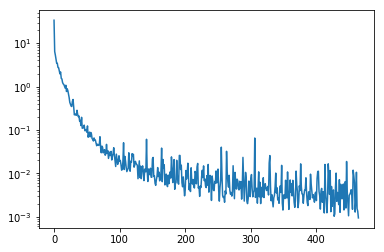

We evaluated the model of the test set and obtained a loss of 0.001164.
Some of the predictions along with the ground truths are shown in the table below:

prediction | ground truth 
 --------- |--------
 12.5817 | 12.5698
 12.3285 | 12.3288
 8.5585 | 8.5440
 12.8013 | 12.8452
 14.1886 | 14.2126
 9.5888 | 9.5916
 11.7209 | 11.7046
 9.8031  | 9.7979
 4.8787 | 4.8989
 12.8064 | 12.8452
 7.7474 | 7.7459
 15.1849 | 15.1986
 12.1996 | 12.2065
 
 As observed, the predicted values are almost always accurate to the first fractional digit. 
 
 To see how well the network has learned the nature of the L1 norm operation, 
 we evaluated it on the test sets generated using different parameters. 
 As a baseline prediction we take the expected L1 norm over the specified distribution:
 
 $$ E[l1norm(V)] = \sqrt{E[L]E[|X|]} $$


min value | max value | max length | min length | baseline loss | test loss 
----------|-----------|------------|------------|---------------|-------------------
-100      |   100     |     1      |     10     |       30.023        |    0.001164
-100      |   100     |     1      |     20     |       54.046      |    0.007786
-100      |   100     |     1      |     50     |       137.8133      |    0.559831
-100      |   100     |     1      |     75     |       207.239      |    8.91298
-100      |   100     |     1      |     100     |      272.6868      |    38.1970
-100      |   100     |     1      |     1000     |      2839.629      |    11078.8017
-100      |   0     |     1      |     10     |      29.08705     |    0.001214
0      |   100     |     1      |     10     |      28.4135      |    0.001228
-10      |   10     |     1      |     10     |      3.0146      |    0.01458
-150     |   150     |     1      |     10     |      43.7239     |    20.214298
-200      |   200     |     1      |     10     |      57.6072      |    41.2819
-1000      |   1000     |     1      |     10     |      285.1246      |    819.8444


Impressively, the network is able to accurately predict the value of l1 norm for 5 times longer vectors than the vectors it was trained on. As observed, the accuracy is high as long as the elements fall in the training range [-100, 100], but deteriorates quickly for if there are elements out of this range.

## Discussion and conclusions

The results show that RNNs can be trained to compute the L1 norm operation with high accuracy over a wide distribution of vectors. However, it remains an open question, wether it is possible to train a network that will compute the operation accuratly for all possible vectors. We tend to doubt it, since neural networks generally perform worse on the unseen inputs and the ability of RNNs to remember long-term dependencies is limited. 

Things we haven't tried:
* In this work we have considered only the vectors of integers, but we think it is possible to achive as high accuracy for the real-valued vectors using the same approach (the network should learn to give less value to the numbers it has seen after the dot). 
* It would be interesting to train a Sequence-to-Sequence model [5], interpreting the ouput as a sequence of characters too. 
* It would be interesting to compare performance with the LSTM cells
* It would be interesting to train a multilayer network

## References

1. Andrej Karpathy, The Unreasonable Effectiveness of Recurrent Neural Networks http://karpathy.github.io/2015/05/21/rnn-effectiveness/

2. Zaremba, Sutskever, "Learning to Execute", CoRR, vol abs/1410.4615, 2014
      https://arxiv.org/pdf/1410.4615.pdf

3. Le, Jaitly, Hinton, "A Simple Way to Initialize Recurrent Networks
      of Rectified Linear Units", CoRR, vol abs/1504.00941, 2015.
      https://arxiv.org/pdf/1504.00941.pdf
      
4. R2Rt, Recurrent Neural Networks in Tensorflow I-III https://r2rt.com/

5. Sutskever, Vinyals, Le, "Sequence to Sequence Learning with Neural Networks", CoRR, vol abs/1409.3215, 2014  https://arxiv.org/pdf/1409.3215.pdf


## Appendix A: Static RNN Implemenatation

A code snippet that 

    def rnn_cell(rnn_input, state):
        b = tf.get_variable('b', [state_size],
                            initializer=zeros_initializer)
        w_xh = tf.get_variable('w_xh', [num_features, state_size],
                                initializer=random_uniform_initializer)
        w_hh = tf.get_variable('w_hh', [state_size, state_size],
                                initializer=indentity_initializer)
        return tf.nn.relu(tf.matmul(rnn_input, w_xh) + tf.matmul(state, w_hh) + b)

    # Adding cells to the graph
    state = init_state
    rnn_outputs = []
    with tf.variable_scope('rnn'):
        for i in range(num_steps):
            rnn_input = rnn_inputs[i]
            if i > 0: tf.get_variable_scope().reuse_variables()
            state = rnn_cell(rnn_input, state)
            rnn_outputs.append(state)
    self.final_state = rnn_outputs[-1]

## Appendix B: Hyperparameters search

|    | batch_size | identity_init | keep_probability | learning_rate     | max_grad_norm | state_size | train_loss       | train_time    | valid_loss       | 
|----|------------|---------------|------------------|-------------------|---------------|------------|------------------|---------------|------------------| 
| 0  | 32         | True          | 1                | 0.000494139333487 | 100.0         | 75         | 0.0043621910736  | 315.594078064 | 0.00440552271903 | 
| 1  | 64         | True          | 1                | 0.00175722895609  | 100.0         | 25         | 0.00799816474319 | 129.830211878 | 0.00790286343545 | 
| 2  | 256        | True          | 1                | 0.00511575503662  | 100.0         | 75         | 0.00878325197846 | 201.898087978 | 0.00870014727116 | 
| 3  | 32         | True          | 1                | 0.000255679675672 | 100.0         | 100        | 0.00876503903419 | 405.885988951 | 0.00897657126188 | 
| 4  | 32         | True          | 1                | 0.00256654230116  | None          | 25         | 0.00941519252956 | 177.284313917 | 0.00941925216466 | 
| 5  | 16         | True          | 1                | 0.00019054905995  | None          | 50         | 0.0144891673699  | 324.314072847 | 0.0143379084766  | 
| 6  | 32         | True          | 1                | 0.000196113424727 | 1000.0        | 75         | 0.0201542936265  | 315.886223793 | 0.0201800260693  | 
| 7  | 256        | False         | 1                | 0.0270921427196   | 100.0         | 75         | 0.0206153914332  | 214.822327137 | 0.0204334314913  | 
| 8  | 16         | True          | 1                | 0.00836471581751  | 100.0         | 75         | 0.0256351660937  | 407.268535137 | 0.0252831690013  | 
| 9  | 128        | True          | 1                | 0.00557608280212  | 1000.0        | 25         | 0.0286740139127  | 105.441124916 | 0.0280437748879  | 
| 10 | 16         | True          | 1                | 0.000209687895273 | 10.0          | 25         | 0.0309659782797  | 276.977946997 | 0.0307220946997  | 
| 11 | 64         | True          | 1                | 0.000870413809207 | 1000.0        | 50         | 0.0358128547668  | 195.583592176 | 0.0349244475365  | 
| 12 | 128        | False         | 1                | 0.00146611359907  | 1.0           | 75         | 0.0353174507618  | 232.465940952 | 0.0357514359057  | 
| 13 | 16         | True          | 1                | 0.00236659601992  | 1.0           | 75         | 0.0394987650216  | 418.956413031 | 0.0387760512531  | 
| 14 | 64         | True          | 1                | 0.00123612806401  | 1000.0        | 75         | 0.0460540130734  | 263.942479134 | 0.0446781255305  | 
| 15 | 16         | True          | 1                | 0.00254146467249  | 1.0           | 75         | 0.0463997833431  | 405.076059103 | 0.045547105372   | 
| 16 | 128        | True          | 1                | 0.0056438023825   | 100.0         | 10         | 0.0492271184921  | 72.1750938892 | 0.0480885095894  | 
| 17 | 128        | True          | 1                | 0.00268062893146  | 1000.0        | 100        | 0.0508028678596  | 294.866906881 | 0.0501164682209  | 
| 18 | 32         | False         | 1                | 0.0210664081598   | 1000.0        | 50         | 0.0599625743926  | 237.936765909 | 0.0596460439265  | 
| 19 | 32         | False         | 1                | 0.0305425256217   | 1000.0        | 10         | 0.0611887313426  | 146.683082104 | 0.0604652613401  | 
| 20 | 64         | True          | 1                | 0.00397646206192  | 1000.0        | 10         | 0.066878169775   | 96.0924677849 | 0.0658682659268  | 
| 21 | 32         | True          | 1                | 0.00669321563795  | 10.0          | 25         | 0.0666678771377  | 177.912431955 | 0.0660198703408  | 
| 22 | 128        | True          | 1                | 0.00535036905806  | 100.0         | 5          | 0.0735322907567  | 61.4250798225 | 0.0704159215093  | 
| 23 | 32         | True          | 1                | 0.00656911891483  | 1000.0        | 5          | 0.0845140069723  | 135.706163883 | 0.0774291902781  | 
| 24 | 128        | False         | 1                | 0.0120889557959   | None          | 10         | 0.0878107398748  | 72.7057759762 | 0.0849923044443  | 
| 25 | 32         | True          | 1                | 0.000123295088516 | 10.0          | 50         | 0.11662428081    | 239.220144987 | 0.117750912905   | 
| 26 | 256        | True          | 1                | 0.00154819844206  | 1000.0        | 100        | 0.124072223902   | 262.591902018 | 0.123306691647   | 
| 27 | 64         | True          | 1                | 0.0288236991747   | 1000.0        | 10         | 0.12853884697    | 96.1771819592 | 0.128759711981   | 
| 28 | 64         | True          | 1                | 0.000115567566566 | 1.0           | 100        | 0.131894230843   | 345.740352154 | 0.130256578326   | 
| 29 | 128        | True          | 1                | 0.0337302581999   | 100.0         | 25         | 0.135693505406   | 105.361760855 | 0.134178817272   | 
| 30 | 16         | False         | 1                | 0.027317013457    | 100.0         | 75         | 0.15581484139    | 406.192559958 | 0.152850329876   | 
| 31 | 256        | True          | 1                | 0.00473045555252  | None          | 25         | 0.191778361797   | 88.8418679237 | 0.185649350286   | 
| 32 | 64         | True          | 1                | 0.000167555775176 | 1000.0        | 50         | 0.218782529235   | 194.983141899 | 0.219480216503   | 
| 33 | 256        | False         | 1                | 0.00830313683405  | 1000.0        | 25         | 0.225611135364   | 88.9641849995 | 0.220408335328   | 
| 34 | 32         | True          | 1                | 0.0364929204786   | 1000.0        | 5          | 0.223634019494   | 136.464811087 | 0.225813791156   | 
| 35 | 32         | True          | 1                | 0.0187356152627   | None          | 10         | 0.269740045071   | 145.262488127 | 0.263993144035   | 
| 36 | 16         | False         | 1                | 0.038973462608    | None          | 10         | 0.267326772213   | 241.617444038 | 0.265505224466   | 
| 37 | 128        | True          | 1                | 0.000329945320845 | None          | 100        | 0.335029512644   | 293.605142117 | 0.333288818598   | 
| 38 | 16         | False         | 1                | 0.00218994208913  | 100.0         | 5          | 0.349466085434   | 232.396193027 | 0.353044003248   | 
| 39 | 128        | True          | 1                | 0.00314023626287  | 1.0           | 5          | 0.364704281092   | 61.8536069393 | 0.356086939573   | 
| 40 | 64         | True          | 1                | 0.0198160756133   | 10.0          | 10         | 0.447931468487   | 95.7705368996 | 0.437546849251   | 
| 41 | 32         | False         | 1                | 0.00041957673944  | 100.0         | 5          | 0.437221556902   | 136.394538879 | 0.440463095903   | 
| 42 | 256        | True          | 1                | 0.00034515861937  | 100.0         | 100        | 0.432900130749   | 260.985924006 | 0.443093121052   | 
| 43 | 256        | True          | 1                | 0.00835096966195  | 10.0          | 50         | 0.449450790882   | 144.942832947 | 0.443516552448   | 
| 44 | 32         | False         | 1                | 0.0545422935482   | None          | 25         | 0.577502131462   | 183.286011219 | 0.574241042137   | 
| 45 | 64         | True          | 1                | 0.00929503164071  | 1.0           | 50         | 0.611375212669   | 196.299347878 | 0.600348830223   | 
| 46 | 16         | False         | 1                | 0.0322508347512   | 100.0         | 5          | 0.798490524292   | 233.536910057 | 0.787398695946   | 
| 47 | 256        | False         | 1                | 0.0312621510532   | 10.0          | 75         | 0.988744497299   | 202.690482855 | 0.970715761185   | 
| 48 | 32         | True          | 1                | 0.000335413952074 | 100.0         | 5          | 1.19891417027    | 136.658046007 | 1.19793450832    | 
| 49 | 64         | True          | 1                | 0.000133759190819 | 100.0         | 25         | 1.21941459179    | 130.57623291  | 1.23529624939    | 
| 50 | 256        | True          | 1                | 0.0103351844571   | 10.0          | 10         | 1.3537760973     | 56.5546791553 | 1.32421374321    | 

